In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


In [2]:
import spacy
from spacy import displacy
import re
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
from spacy.util import filter_spans
from spacy.pipeline import EntityRuler
from tqdm import tqdm



In [3]:
from spacy.cli import download

download("en_core_web_sm")
download("en_core_web_lg")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
def load_data(name):
    path = f"/kaggle/input/conll003-englishversion/{name}.txt"
    tokens, labels = [], []
    sentence_tokens, sentence_labels = [], []
    tokens_count = 0

    f = open(path, "r")
    lines = f.readlines()
    f.close()

    for line in lines:
        if line.startswith("-DOCSTART-"):
            continue

        parts = line.split(" ")
        if not parts[0]:
            continue

        if parts[0].startswith("\n") and sentence_tokens:
            sentence_tokens = sentence_tokens[1:]
            sentence_labels = sentence_labels[1:]
            tokens.append(sentence_tokens)
            labels.append(sentence_labels)
            sentence_tokens, sentence_labels = [], []
            continue

        first = parts[0].strip()
        label = parts[-1].strip()
        sentence_tokens.append(first)
        sentence_labels.append(label)
        tokens_count += 1

    return tokens, labels, tokens_count


In [5]:
train_tokens, train_labels, train_count = load_data("train")
val_tokens, val_labels, val_count = load_data("valid")
test_tokens, test_labels, test_count = load_data("test")

# Using Model-Based NER

## Exploring en_core_web_lg

In [6]:
lg_model = spacy.load("en_core_web_lg")

sentences_sample = [" ".join(x) for x in train_tokens[0:5]]
sample_docs = [lg_model(x) for x in sentences_sample]
print(sample_docs[0])


EU rejects German call to boycott British lamb .


Visualizing en_core_web_lg

In [7]:
for doc in sample_docs:
    displacy.render(doc, style="ent", jupyter= True)

## Exploring en_core_web_sm

In [8]:
sm_model = spacy.load("en_core_web_sm")

sentences_sample = [" ".join(x) for x in train_tokens[0:5]]
sample_docs = [sm_model(x) for x in sentences_sample]

# Using Rule-Based Raw Model

In [9]:
rule_model = spacy.blank("en")
ruler = rule_model.add_pipe("entity_ruler", config={"overwrite_ents":True})

COUNTRIES = ["United States", "United Kingdom", "Germany", "France", "Egypt", "USA", "UK", "China", "Japan", "Spain", "Italy"]
ORG_SUFFIX = ["inc.", "ltd.", "corp.", "co.", "bank", "university", "college", "group", "committee", "council"]
NATIONALITY_ADJ = ["american","british","german","french","egyptian","chinese","japanese","spanish","italian"]

patterns = (
    [
        {"label": "PER", "pattern": [{"LOWER": {"IN": ["mr.","mrs.","ms.","dr.","prof."]}}, {"IS_TITLE": True, "OP": "+"}]},

        {"label": "PER", "pattern": [{"IS_TITLE": True}, {"IS_TITLE": True, "OP": "+"}]},

        {"label": "ORG", "pattern": [{"IS_TITLE": True, "OP": "+"}, {"LOWER": {"IN": ORG_SUFFIX}}]},

        {"label": "ORG", "pattern": [{"TEXT": {"REGEX": "^[A-Z]{2,6}$"}}]},

        {"label": "LOC", "pattern": [{"LOWER": {"IN": ["in","at","from","to"]}}, {"IS_TITLE": True, "OP": "+"}]},
    ]
    + [{"label": "LOC", "pattern": c} for c in COUNTRIES]
    + [{"label": "MISC", "pattern": [{"LOWER": nat}]} for nat in NATIONALITY_ADJ]
)

In [10]:
ruler.add_patterns(patterns)


In [11]:
text = "Sarah traveled to France last year, where she visited the Eiffel Tower and studied at Sorbonne University in Paris."
doc = rule_model(text)

options = {
    "colors": {
        "LOC": "#ff6961",   # red-ish
        "ORG": "#77dd77",   # green
        "PER": "#779ecb",   # blue
        "MISC": "#fdfd96"   # yellow
    }
}

displacy.render(doc, style="ent", options=options, jupyter=True)


# Using Rule-Based Pretrained Model en_core_web_lg

In [12]:
pretrained_rule_model = spacy.load("en_core_web_lg")
pretrained_ruler = pretrained_rule_model.add_pipe("entity_ruler")

pretrained_ruler.add_patterns(patterns)


In [13]:
doc = pretrained_rule_model("Sarah traveled to France last year, where she visited the Eiffel Tower and studied at Sorbonne University in Paris.")

colors = {
    "LOC": "#ff6961",   # red-ish
    "ORG": "#77dd77",   # green
    "PER": "#779ecb",   # blue
    "MISC": "#fdfd96",  # yellow
}
options = {"colors": colors}

spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

In [14]:
def sentence_to_text_and_token_char_spans(tokens):
    text_parts, spans, pos = [], [], 0
    for i, tok in enumerate(tokens):
        if i: text_parts.append(" "); pos += 1
        start = pos
        text_parts.append(tok); pos += len(tok)
        spans.append((start, pos))
    return "".join(text_parts), spans

def base_label(lbl):
    if lbl in ("PER","PERSON"): return "PER"
    if lbl in ("ORG",):         return "ORG"
    if lbl in ("LOC","GPE"):    return "LOC"
    return "MISC"

def ents_to_bio_for_tokens(doc, token_spans):
    ents = sorted(filter_spans(list(doc.ents)), key=lambda e: (e.end_char - e.start_char), reverse=True)
    bio = ["O"] * len(token_spans)
    for ent in ents:
        ent_start, ent_end = ent.start_char, ent.end_char
        covered = [i for i,(s,e) in enumerate(token_spans) if s >= ent_start and e <= ent_end]
        if not covered:  # fallback to any overlap
            covered = sorted({i for i,(s,e) in enumerate(token_spans) if not (e <= ent_start or s >= ent_end)})
        b = base_label(ent.label_)
        for j, ti in enumerate(covered):
            if bio[ti] != "O":  # keep earlier longer span
                continue
            bio[ti] = f"{'B' if j==0 else 'I'}-{b}"
    return bio

def evaluate_bio(nlp, test_tokens, test_labels):
    y_true, y_pred = [], []
    for tokens, gold_bio in zip(test_tokens, test_labels):
        text, tok_spans = sentence_to_text_and_token_char_spans(tokens)
        pred_bio = ents_to_bio_for_tokens(nlp(text), tok_spans)
        m = min(len(pred_bio), len(gold_bio))
        y_true.extend(gold_bio[:m])
        y_pred.extend(pred_bio[:m])
    labels_no_o = sorted({t for t in set(y_true) | set(y_pred) if t != "O"})
    acc = sum(a==b for a,b in zip(y_true,y_pred)) / len(y_true) * 100
    print(f"Overall token accuracy (incl. 'O'): {acc:.2f}%\n")
    return acc

print("1. en_core_web_lg")
lg_acc = evaluate_bio(lg_model, test_tokens, test_labels)

print("2. en_core_web_sm")
sm_acc = evaluate_bio(sm_model, test_tokens, test_labels)

print("3. Raw rule_model")
rule_acc = evaluate_bio(rule_model, test_tokens, test_labels)

print("4. pretrained en_core_web_lg")
pretrained_rule_acc = evaluate_bio(pretrained_rule_model, test_tokens, test_labels)

1. en_core_web_lg
Overall token accuracy (incl. 'O'): 80.97%

2. en_core_web_sm
Overall token accuracy (incl. 'O'): 80.17%

3. Raw rule_model
Overall token accuracy (incl. 'O'): 87.18%

4. pretrained en_core_web_lg
Overall token accuracy (incl. 'O'): 80.25%



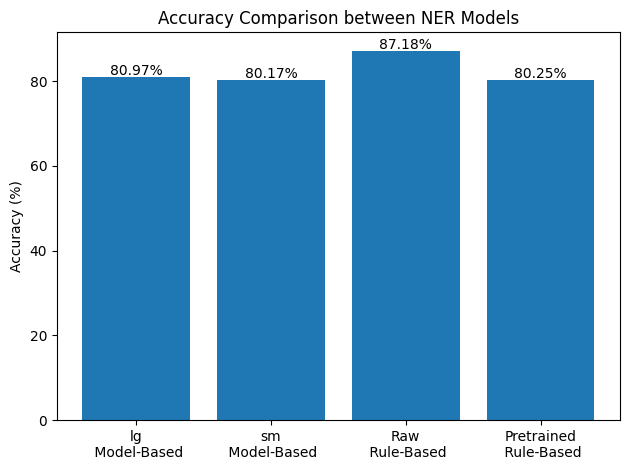

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

models = ["lg\n Model-Based", "sm\n Model-Based", "Raw\n Rule-Based", "Pretrained\n Rule-Based"]
scores = [lg_acc, sm_acc, rule_acc, pretrained_rule_acc]

ax.bar(
    models,
    scores,
)

ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy Comparison between NER Models")

for idx, val in enumerate(scores):
    ax.text(idx, val + 0.5, f"{val:.2f}%", ha="center")

plt.tight_layout()
plt.show()
